In [1]:
import pandas as pd
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

VNA_data = genfromtxt('../input/van-2/VAN.csv', delimiter=',') #in the form of [t,S,I,R]

torch.manual_seed(1234)
print(VNA_data)

[[ 0.    4.06  7.45 11.74 24.39 36.35 48.1  71.8 ]
 [88.5  90.   84.   73.   50.   15.    3.    1.5 ]
 [ 2.    3.    6.   10.   12.    9.    4.    2.5 ]
 [ 9.5   8.   10.   17.   33.   76.   93.   96.  ]]


In [2]:
%%time

PATH = 'sir_norm_simple' 

class DINN(nn.Module):
    def __init__(self, t, S_data, I_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        self.N = 100 #population size
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.R = torch.tensor(R_data)

        self.losses = []
        self.save = 2 #which file to save to

        self.Kan_tilda = torch.nn.Parameter(torch.rand(1, dtype=torch.float64, requires_grad=True))
        self.Kav_tilda = torch.nn.Parameter(torch.rand(1, dtype=torch.float64, requires_grad=True))
        self.Kva_tilda = torch.nn.Parameter(torch.rand(1, dtype=torch.float64, requires_grad=True))
        self.Kvn_tilda = torch.nn.Parameter(torch.rand(1, dtype=torch.float64, requires_grad=True))
        
        #find values for normalization
        self.S_max = max(self.S)
        self.I_max = max(self.I)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.I_min = min(self.I)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)

        #matrices (x4 for S,I,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 4)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 4)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 4)); self.m3[:, 2] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.Kan_tilda, self.Kav_tilda, self.Kva_tilda, self.Kvn_tilda]))

    @property
    def Kva(self):
        return self.Kva_tilda

    @property
    def Kan(self):
        return self.Kan_tilda
    
    @property
    def Kav(self):
        return self.Kav_tilda
    
    @property
    def Kvn(self):
        return self.Kvn_tilda
    
    #nets
    class Net_sidr(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 4) #outputs S, I, R

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr
            
    def net_f(self, t_batch):
        sidr_hat = self.net_sidr(t_batch)

        S_hat, I_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m2, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m3, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat   
        R = self.R_min + (self.R_max - self.R_min) * R_hat

        f1_hat = S_hat_t - (- (self.Kva + self.Kvn) * S + self.Kav * I)  / (self.S_max - self.S_min)
        f2_hat = I_hat_t - ( self.Kva * S - (self.Kav + self.Kan) * I) / (self.I_max - self.I_min)
        f3_hat = R_hat_t - (self.Kvn * S + self.Kan * I ) / (self.R_max - self.R_min)

        return f1_hat, f2_hat, f3_hat, S_hat, I_hat, R_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        self.losses = checkpoint['losses']

      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        I_pred_list = []
        R_pred_list = []

        f1, f2, f3, S_pred, I_pred, R_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred) 
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
        R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)

        train_day = 8

        loss = (torch.mean(torch.square(self.S_hat[:train_day] - S_pred[:train_day]))+ 
                torch.mean(torch.square(self.I_hat[:train_day] - I_pred[:train_day]))+
                torch.mean(torch.square(self.R_hat[:train_day] - R_pred[:train_day]))+
                torch.mean(torch.square(f1[:train_day]))+
                torch.mean(torch.square(f2[:train_day]))+
                torch.mean(torch.square(f3[:train_day]))
                ) 

        #loss.backward(retain_graph=True)
        loss.backward()
        self.optimizer.step()
        self.scheduler.step() 
        self.losses.append(loss.item())

        if epoch % 5000 == 0:          
          print('\nEpoch ', epoch)

          print('Kva: ', self.Kva)
          print('Kav:', self.Kav)
          print('Kan:', self.Kan)
          print('Kvn:', self.Kvn)

          print('#################################')                

      return S_pred_list, I_pred_list, R_pred_list

CPU times: user 49 µs, sys: 7 µs, total: 56 µs
Wall time: 60.6 µs


In [3]:
%%time

dinn = DINN(VNA_data[0], VNA_data[1], VNA_data[2],
            VNA_data[3]) #in the form of [t,S,I,R]

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=5, mode="exp_range", cycle_momentum=False)

dinn.scheduler = scheduler

nepochs = int(5e4)

# S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(nepochs) #train

try: 
  S_pred_list, I_pred_list, R_pred_list = dinn.train(nepochs) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list, I_pred_list, R_pred_list = dinn.train(nepochs) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list, I_pred_list, R_pred_list = dinn.train(nepochs) #train


starting training...


Epoch  0
Kva:  Parameter containing:
tensor([0.4664], dtype=torch.float64, requires_grad=True)
Kav: Parameter containing:
tensor([0.0788], dtype=torch.float64, requires_grad=True)
Kan: Parameter containing:
tensor([0.2318], dtype=torch.float64, requires_grad=True)
Kvn: Parameter containing:
tensor([0.4144], dtype=torch.float64, requires_grad=True)
#################################

Epoch  5000
Kva:  Parameter containing:
tensor([0.0061], dtype=torch.float64, requires_grad=True)
Kav: Parameter containing:
tensor([-0.0882], dtype=torch.float64, requires_grad=True)
Kan: Parameter containing:
tensor([0.1046], dtype=torch.float64, requires_grad=True)
Kvn: Parameter containing:
tensor([0.0024], dtype=torch.float64, requires_grad=True)
#################################

Epoch  10000
Kva:  Parameter containing:
tensor([0.0056], dtype=torch.float64, requires_grad=True)
Kav: Parameter containing:
tensor([-0.1497], dtype=torch.float64, requires_grad=True)
Kan: Parameter co

total loss 0.00048538794553765
Kva:  Parameter containing:
tensor([0.0014], dtype=torch.float64, requires_grad=True)
Kav: Parameter containing:
tensor([-0.2233], dtype=torch.float64, requires_grad=True)
Kan: Parameter containing:
tensor([0.2388], dtype=torch.float64, requires_grad=True)
Kvn: Parameter containing:
tensor([-0.0081], dtype=torch.float64, requires_grad=True)


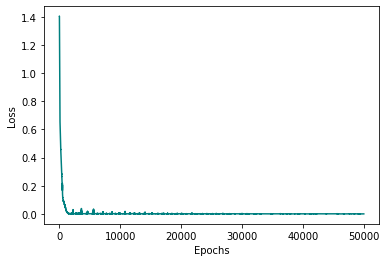

In [4]:
plt.plot(dinn.losses, color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')
print('total loss', dinn.losses[-1])
print('Kva: ', dinn.Kva)
print('Kav:', dinn.Kav)
print('Kan:', dinn.Kan)
print('Kvn:', dinn.Kvn)

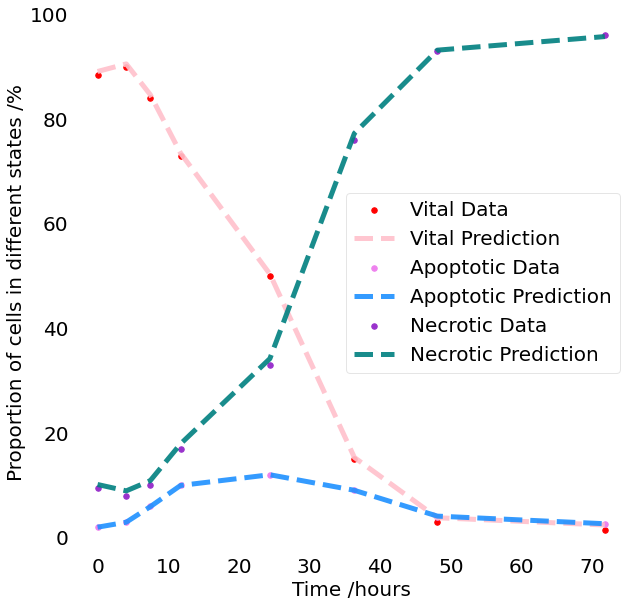

In [5]:
fig = plt.figure(figsize=(10,10))
sidr_data = VNA_data
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.scatter(sidr_data[0], sidr_data[1], color = 'red', label='Vital Data', s=30)
ax.plot(sidr_data[0], S_pred_list[0].detach().numpy(), 'pink', alpha=0.9, lw=5, label='Vital Prediction', linestyle='dashed')

ax.scatter(sidr_data[0], sidr_data[2], color = 'violet', label='Apoptotic Data', s=30)
ax.plot(sidr_data[0], I_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=5, label='Apoptotic Prediction', linestyle='dashed')

ax.scatter(sidr_data[0], sidr_data[3], color = 'darkorchid', label='Necrotic Data', s=30)
ax.plot(sidr_data[0], R_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=5, label='Necrotic Prediction', linestyle='dashed')

ax.set_xlabel('Time /hours',size = 20)
ax.set_ylabel('Proportion of cells in different states /%',size = 20)
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
plt.xticks(size = 20)
plt.yticks(size = 20)
# ax.grid(b=True, which='major', c='black', lw=2.2, ls=15-')
legend = ax.legend(prop={'size':20})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('output_5')
plt.show()
